In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import PowerTransformer

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow as tf
from tensorflow import keras

In [3]:
def fun_pipeline(dataframe, market, list_time_series):
    #dates
    month_as_date = [str(x)[:4] + '-' + str(x)[4:] for x in dataframe['04 FISCAL MONTH']]
    month_as_date = np.array(month_as_date, dtype='datetime64')
    #grouping
    original_granularity_set = ['04 FISCAL MONTH',
                                '03 MARKET',
                                'Warranty Measures Hierarchy Level 04 (Label Only)',
                                'Sum of AMOUNT or UNIT - WARRANTY']
    dataframe = dataframe[original_granularity_set]
    dataframe.columns = ['month', 'market', 'line_cost', 'value']
    dataframe['month'] = month_as_date
    dataframe = dataframe.groupby(by=['month', 'market', 'line_cost'])['value'].sum()
    dataframe = dataframe.unstack().loc[pd.IndexSlice[:, market], :].droplevel('market')
    dataframe = dataframe[list_time_series]
    #outliers
    line_cost_complete = list_time_series
    for variable_name in line_cost_complete:
        var = dataframe[variable_name]
        q1 = var.quantile(0.25)
        q3 = var.quantile(0.75)
        iqr = q3 - q1

        for x, dates in zip(var[(var < q1-1.5*iqr)|(var > q3+1.5*iqr)|(pd.isnull(var))|(var < 0)], var[(var < q1-1.5*iqr)|(var > q3+1.5*iqr)|(pd.isnull(var))|(var < 0)].index):
            #because we belive it is a cicle of each Q then we use the correspondent month from the previous quarter
            #print(x, dates, var[np.datetime64(dates, 'M') - 3])
            if (np.datetime64(dates, 'M') - 3) >= np.datetime64('2016-11', 'M'):
                var[dates] = var[np.datetime64(dates, 'M') - 3]
            else:
                var[dates] = var[np.datetime64(dates, 'M') + 3]
    
    #only for this to cost types because the time series is incomplete
    line_cost_incomplete = ['Delivery OH', 'Supply Chain OH']
    if line_cost_incomplete[0] in dataframe.columns:
        for variable_name in line_cost_incomplete:
            var = dataframe[variable_name].loc['2020-11':]
            q1 = var.quantile(0.25)
            q3 = var.quantile(0.75)
            iqr = q3 - q1

            for x, dates in zip(var[(var < q1-1.5*iqr)|(var > q3+1.5*iqr)|(pd.isnull(var))|(var < 0)], var[(var < q1-1.5*iqr)|(var > q3+1.5*iqr)|(pd.isnull(var))|(var < 0)].index):
                #because we belive it is a cicle of each Q then we use the correspondent month from the previous quarter
                #print(x, dates, var[np.datetime64(dates, 'M') - 3])
                if (np.datetime64(dates, 'M') - 3) >= np.datetime64('2020-11', 'M'):
                    var[dates] = var[np.datetime64(dates, 'M') - 3]
                else:
                    var[dates] = var[np.datetime64(dates, 'M') + 3]

            dataframe[variable_name].loc[:'2020-10'] = np.nan
    #transformers
    dataframe_transformer = PowerTransformer(method='box-cox', standardize=True, copy=True)
    dataframe_trn_std = dataframe_transformer.fit_transform(dataframe)
    dataframe_trn_std = pd.DataFrame(dataframe_trn_std, columns=dataframe.columns, index=dataframe.index)

    return dataframe_transformer, dataframe_trn_std, dataframe

In [4]:
def fun_pipeline_test(dataframe, market, list_time_series):
    #dates
    month_as_date = [str(x)[:4] + '-' + str(x)[4:] for x in dataframe['04 FISCAL MONTH']]
    month_as_date = np.array(month_as_date, dtype='datetime64')
    #grouping
    original_granularity_set = ['04 FISCAL MONTH',
                                '03 MARKET',
                                'Warranty Measures Hierarchy Level 04 (Label Only)',
                                'Sum of AMOUNT or UNIT - WARRANTY']
    dataframe = dataframe[original_granularity_set]
    dataframe.columns = ['month', 'market', 'line_cost', 'value']
    dataframe['month'] = month_as_date
    dataframe = dataframe.groupby(by=['month', 'market', 'line_cost'])['value'].sum()
    dataframe = dataframe.unstack().loc[pd.IndexSlice[:, market], :].droplevel('market')
    dataframe = dataframe[list_time_series]

    return dataframe

In [93]:
data_raw = pd.read_excel('dataset_cost.xlsx')
data_test = data_raw[data_raw['04 FISCAL MONTH'].isin([202210, 202209, 202208])]
data_train = data_raw[~data_raw['04 FISCAL MONTH'].isin([202210, 202209, 202208])]
data_train.shape, data_test.shape

((17782, 11), (1103, 11))

In [94]:
#list_of_costs = ['CS HQ Owned and Allocated', 'Contact Center Expense', 'Contact Center OH', 'Delivery', 'GBU Owned and Allocated', 'Supply Chain']
list_of_costs = ['CS HQ Owned and Allocated']
market = 'North America Market'
transformer_train, train, train_no_trnsfrmd = fun_pipeline(data_train, market, list_of_costs)
test = fun_pipeline_test(data_test, market, list_of_costs)

C:\Users\nuno\AppData\Local\Temp\ipykernel_8896\3201569793.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] = month_as_date
C:\Users\nuno\AppData\Local\Temp\ipykernel_8896\1933681758.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] = month_as_date


In [95]:
reg_data_act_raw = pd.read_excel('dataset_reg.xlsx', 'actuals')
#reg_data_act_test = reg_data_act_raw[reg_data_act_raw['04 FISCAL MONTH'].isin([202210, 202209, 202208])]
#reg_data_act_train = reg_data_act_raw[~reg_data_act_raw['04 FISCAL MONTH'].isin([202210, 202209, 202208])]
reg_data_act_train = reg_data_act_raw.copy()

#puedes traer toda la información por que son valores ya conocidos que sera usados como X

list_of_regresors = ['AIR (Avg)', 'Assisted E-Suppt Interactions', 'Net Revenues', 'Total Number of Calls', 'Total Number of Repair Events', 'WIB', 'Warranty Units Adjusted']
transformer_train_reg, train_reg, train_reg_no_trnsfrmd = fun_pipeline(reg_data_act_train, market, list_of_regresors)

C:\Users\nuno\AppData\Local\Temp\ipykernel_8896\3201569793.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] = month_as_date


## Train model

In [96]:
#set lags
line_cost_y = list_of_costs[0]
timesteps = 4
timesteps_fwd = 3

var = train[line_cost_y].values.reshape(-1, 1)
var_timesteps = np.array([[j for j in var[i:i+timesteps]]
                            for i in range(0,len(var)-timesteps+1)])[:,:,0]

X, y = var_timesteps[:,:timesteps-1], var_timesteps[:,[timesteps-1]]
y = y.ravel()
X.shape, y.shape

((66, 3), (66,))

In [97]:
X_others_reg = train_reg.values[timesteps-1:-timesteps_fwd,:]
X = np.column_stack((X, X_others_reg))
X.shape

(66, 10)

In [98]:
nnet=keras.Sequential([
                       keras.Input(shape=(10,)),
                       Dense(11,activation=tf.nn.tanh),
                       Dense(1,activation='linear')
])
nnet.compile(loss='mean_squared_error',optimizer='sgd')
nnet.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 11)                121       
                                                                 
 dense_17 (Dense)            (None, 1)                 12        
                                                                 
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


In [99]:
nnet.fit(X,y,epochs=5000, verbose = False)

c:\Users\nuno\Miniconda3\envs\ml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


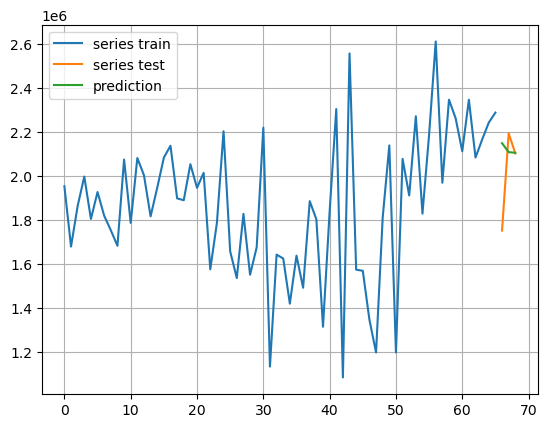

In [100]:
#last supposedly known value, fwd ones are already known as flash
timesteps_fwd = 3
var_pred = var.copy()

for t_x in range(timesteps_fwd):
    X_others_reg = train_reg.values[-timesteps+t_x:-timesteps+1+t_x].reshape(-1,1)
    XX = np.vstack((var_pred[len(var_pred) - timesteps+1:], X_others_reg))
    y_hat_tplus1 = nnet(XX.reshape(1,10))
    var_pred = np.concatenate((var_pred, y_hat_tplus1))

x_prds_plt = len(train[timesteps-1:].values)

plt.plot(range(x_prds_plt), train_no_trnsfrmd[timesteps-1:].values,label='series train')
plt.plot(range(x_prds_plt,x_prds_plt+timesteps_fwd), test, label='series test')
plt.plot(range(x_prds_plt,x_prds_plt+timesteps_fwd), transformer_train.inverse_transform(var_pred[-(timesteps_fwd):]), label='prediction')
plt.legend()
plt.grid()

## accuracy

In [101]:
(test - transformer_train.inverse_transform(var_pred[-(timesteps_fwd):]))/test

c:\Users\nuno\Miniconda3\envs\ml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


line_cost,CS HQ Owned and Allocated
month,
2022-08-01,-0.227528
2022-09-01,0.039221
2022-10-01,-0.001426


## arbol

In [102]:
from sklearn.ensemble import RandomForestRegressor

model_tree = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               max_depth=None,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features='auto',
                               bootstrap=True,
                               oob_score=False,
                               random_state=0,
                               verbose=1)
model_tree = model_tree.fit(X, y) # prediction with random forest

c:\Users\nuno\Miniconda3\envs\ml\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.7s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
c:\Users\nuno\Miniconda3\envs\ml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


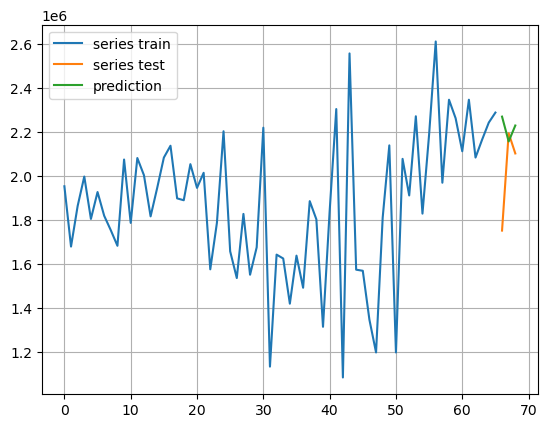

In [103]:
#last supposedly known value, fwd ones are already known as flash
var_pred_tree = var.copy()

for t_x in range(timesteps_fwd):
    X_others_reg = train_reg.values[-timesteps+t_x:-timesteps+1+t_x].reshape(-1,1)
    XX = np.vstack((var_pred_tree[len(var_pred_tree) - timesteps+1:], X_others_reg))
    y_hat_tplus1 = model_tree.predict(XX.reshape(1,10))
    var_pred_tree = np.concatenate((var_pred_tree, y_hat_tplus1.reshape(1,1)))

x_prds_plt = len(train[timesteps-1:].values)

plt.plot(range(x_prds_plt), train_no_trnsfrmd[timesteps-1:].values,label='series train')
plt.plot(range(x_prds_plt,x_prds_plt+timesteps_fwd), test, label='series test')
plt.plot(range(x_prds_plt,x_prds_plt+timesteps_fwd), transformer_train.inverse_transform(var_pred_tree[-(timesteps_fwd):]), label='prediction')
plt.legend()
plt.grid()

In [105]:
type((test - transformer_train.inverse_transform(var_pred_tree[-(timesteps_fwd):]))/test)

c:\Users\nuno\Miniconda3\envs\ml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


pandas.core.frame.DataFrame

because you have multiple time series, you want to evaluate how good each model performs. In general, you want to see which kind of model has less errors, how well it performss the farther it is and if in general provide overestimated or underestimated values.

to be comparable, the error is calculated as a percentage.

- because you need to do it multiple times yet, i don't want to do optimez hyperparameters. just need to compara models in basis.
- because the data is dependant of already known values "flashed data" which is from others, if theirs is wrong then ours is wrong and is their fault.

In [106]:
error_tree_df = pd.DataFrame()

In [107]:
error_tree_df

""


In [ ]:
#list_of_costs = ['CS HQ Owned and Allocated', 'Contact Center Expense', 'Contact Center OH', 'Delivery', 'GBU Owned and Allocated', 'Supply Chain']
for variable in list_of_costs:
    market = 'North America Market'
    transformer_train, train, train_no_trnsfrmd = fun_pipeline(data_train, market, variable)
    test = fun_pipeline_test(data_test, market, variable)

    reg_data_act_raw = pd.read_excel('dataset_reg.xlsx', 'actuals')
    reg_data_act_train = reg_data_act_raw.copy()

    list_of_regresors = ['AIR (Avg)', 'Assisted E-Suppt Interactions', 'Net Revenues', 'Total Number of Calls', 'Total Number of Repair Events', 'WIB', 'Warranty Units Adjusted']
    transformer_train_reg, train_reg, train_reg_no_trnsfrmd = fun_pipeline(reg_data_act_train, market, list_of_regresors)

    #set lags
    line_cost_y = list_of_costs[0]
    timesteps = 4
    timesteps_fwd = 3

    var = train[line_cost_y].values.reshape(-1, 1)
    var_timesteps = np.array([[j for j in var[i:i+timesteps]]
                                for i in range(0,len(var)-timesteps+1)])[:,:,0]

    X, y = var_timesteps[:,:timesteps-1], var_timesteps[:,[timesteps-1]]
    y = y.ravel()
    X.shape, y.shape

    X_others_reg = train_reg.values[timesteps-1:-timesteps_fwd,:]
    X = np.column_stack((X, X_others_reg))
    X.shape

    #neural net
    nnet=keras.Sequential([
                        keras.Input(shape=(10,)),
                        Dense(11,activation=tf.nn.tanh),
                        Dense(1,activation='linear')
    ])
    nnet.compile(loss='mean_squared_error',optimizer='sgd')
    nnet.summary()

    nnet.fit(X,y,epochs=5000, verbose = False)

    #last supposedly known value, fwd ones are already known as flash
    timesteps_fwd = 3
    var_pred = var.copy()

    for t_x in range(timesteps_fwd):
        X_others_reg = train_reg.values[-timesteps+t_x:-timesteps+1+t_x].reshape(-1,1)
        XX = np.vstack((var_pred[len(var_pred) - timesteps+1:], X_others_reg))
        y_hat_tplus1 = nnet(XX.reshape(1,10))
        var_pred = np.concatenate((var_pred, y_hat_tplus1))

    x_prds_plt = len(train[timesteps-1:].values)
    #erros
    error_nnet = (test - transformer_train.inverse_transform(var_pred[-(timesteps_fwd):]))/test

    #tree
    model_tree = RandomForestRegressor(n_estimators=1000,
                                criterion='mse',
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_features='auto',
                                bootstrap=True,
                                oob_score=False,
                                random_state=0,
                                verbose=1)
    model_tree = model_tree.fit(X, y) # prediction with random forest
    #last supposedly known value, fwd ones are already known as flash
    var_pred_tree = var.copy()

    for t_x in range(timesteps_fwd):
        X_others_reg = train_reg.values[-timesteps+t_x:-timesteps+1+t_x].reshape(-1,1)
        XX = np.vstack((var_pred_tree[len(var_pred_tree) - timesteps+1:], X_others_reg))
        y_hat_tplus1 = model_tree.predict(XX.reshape(1,10))
        var_pred_tree = np.concatenate((var_pred_tree, y_hat_tplus1.reshape(1,1)))
    
    error_tree = (test - transformer_train.inverse_transform(var_pred_tree[-(timesteps_fwd):]))/test